In [1]:
# Core
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import expit as sigmoid, logit

# Symbolic math
import sympy
from sympy import diff

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Local imports
from asteroid_data import load_ast_elt
from candidate_element import orbital_element_batch, perturb_elts, random_elts
from candidate_element import score_by_elt, score_batches, report_v, plot_v
from candidate_element import mixture_log_like, mixture_objective_all, mixture_objective, mixture_jacobian, mixture_hessian
from ztf_data import load_ztf_nearest_ast, load_ztf_batch, elt_hash
from ztf_data import make_ztf_batch, calc_hit_freq

In [2]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Batches of Orbital Elements: Unperturbed, Perturbed, Random

In [3]:
# Load all the asteroid elements
ast_elt = load_ast_elt()

In [4]:
ast_elt

,Num,Name,epoch_mjd,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri
Num,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,58600.0,0.822197,0.237862,0.220677,5.066979,3.770460,0.503214,21.55,0.15,JPL 1,0.807024,272.309165,0.023074,-3.225717,-2.921908,-3.728932,-21.808984
1255501,1255501,2019 QL,58600.0,2.722045,0.530676,0.113833,4.741919,2.351059,5.297173,19.21,0.15,JPL 1,-2.082964,1640.368337,0.003830,-0.176219,-1.273172,0.809793,257.420824
1255502,1255502,2019 QQ,58600.0,1.053137,0.389091,0.172121,5.648270,2.028352,3.266522,25.31,0.15,JPL 1,-3.081905,394.753268,0.015917,-1.623227,-1.688469,1.393436,189.527723


In [5]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [6]:
ztf_ast

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1208789,0.005029,41.396388,58.592038,0.390926,0.655662,0.645976
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1227812,0.024428,33.729101,64.536183,0.357570,0.578168,0.733393
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1169677,0.015510,29.207596,64.817653,0.371401,0.550472,0.747691
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1251951,0.012386,30.227911,65.945543,0.352183,0.551505,0.756181
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1246591,0.025343,34.169666,64.771024,0.352659,0.579473,0.734740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697957,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1102168,0.036944,253.707834,53.408139,-0.167230,-0.205583,0.964246
5697958,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1028157,0.084402,224.967815,54.919912,-0.406617,-0.047125,0.912382
5697959,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,539940,0.052254,240.693936,56.155104,-0.272611,-0.115218,0.955200
5697960,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1246304,0.014054,285.998189,34.657915,0.226704,-0.499251,0.836274


In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Set batch size
# batch_size = 1000
batch_size = 64

# Batch of unperturbed elements
elts = orbital_element_batch(ast_nums=ast_num_best[0:batch_size])

# Add hit_count column
elts['hit_count'] = hit_count_best[0:batch_size]

elts

,element_id,a,e,inc,Omega,omega,f,epoch,hit_count
0,51921,2.669306,0.217361,0.499554,4.699703,2.450796,-1.133491,58600.0,194
1,59244,2.634727,0.262503,0.465045,5.738297,1.766995,-1.601363,58600.0,190
2,15786,1.883227,0.047655,0.392360,6.134689,0.804823,-1.246069,58600.0,189
3,3904,2.556387,0.098279,0.261542,5.450163,2.202423,-1.357345,58600.0,188
4,142999,2.619944,0.191376,0.514017,0.238022,0.946463,-1.299301,58600.0,186
...,...,...,...,...,...,...,...,...,...
59,11952,2.219650,0.086091,0.117967,0.042442,2.904823,-3.016580,58600.0,148
60,134815,2.612770,0.140831,0.513923,0.272689,0.645552,-0.957836,58600.0,148
61,27860,2.619406,0.096185,0.200633,5.541399,3.266046,3.948770,58600.0,148
62,85937,2.342292,0.197267,0.439063,5.279693,3.210025,3.947687,58600.0,148


In [9]:
np.mean(elts.hit_count)

161.453125

In [10]:
# Alias elts to elts_ast for naming consistency with elts_pert and elts_rand
elts_ast = elts.copy()

In [11]:
# Perturb orbital elements
sigma_a = 0.0 
sigma_e = 0.0 
sigma_f_deg = 0.1
sigma_Omega_deg = 0.0
sigma_omega_deg = 0.0
mask_pert = None
random_seed = 42

elts_pert = perturb_elts(elts, sigma_a=sigma_a, sigma_e=sigma_e, sigma_f_deg=sigma_f_deg, 
                         sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                         mask_pert=mask_pert, random_seed=random_seed)

In [12]:
# Batch of random elements
elts_rand = random_elts(element_id_start=0, size=batch_size, random_seed=42)

## Batches of ZTF Data vs. Elements

In [13]:
# Arguments to make_ztf_batch
# thresh_deg = 10.0
thresh_deg = 1.0
near_ast = False

In [14]:
# Load unperturbed element batch
ztf_elt_ast = load_ztf_batch(elts=elts_ast, thresh_deg=thresh_deg, near_ast=near_ast)

In [15]:
# Review 
ztf_elt_ast

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,dist_sec,z,v,score,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,-0.063945,-0.983101,...,-0.057300,-0.982042,0.179751,2.234078,0.010624,2191.371398,0.999944,0.370539,0.009739,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,-0.071871,-0.982578,...,-0.057300,-0.982042,0.179751,2.234078,0.016809,3467.103003,0.999859,0.927533,0.000009,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,0.005674,-0.977422,...,0.000918,-0.977996,0.208622,2.703478,0.005450,1124.142942,0.999985,0.097510,0.295572,False
3,257221,733,b'ZTF18acakcqg',931471223715015007,39920,58685.471227,29.693832,42.180412,0.643725,0.603886,...,0.639004,0.610779,0.467571,2.175851,0.008712,1797.042210,0.999962,0.249184,0.044390,False
4,327000,733,b'ZTF18achmdmw',937465970615015011,40837,58691.465972,33.104905,44.059131,0.601970,0.636719,...,0.606278,0.637608,0.475272,2.114865,0.007949,1639.537152,0.999968,0.207418,0.074820,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90205,5650588,324582,b'ZTF20aaqvhld',1150176701515015008,96618,58904.176701,44.164238,29.650540,0.623416,0.752309,...,0.627640,0.750696,0.206212,2.981799,0.008187,1688.636853,0.999966,0.220027,0.063910,False
90206,5650589,324582,b'ZTF20aaqvhld',1150176245715015005,96617,58904.176250,44.164062,29.650536,0.623417,0.752307,...,0.627641,0.750695,0.206213,2.981793,0.008187,1688.600639,0.999966,0.220018,0.063917,False
90207,5650665,324582,b'ZTF20aaqvhll',1150176245815015010,96617,58904.176250,44.368640,28.490480,0.628284,0.753618,...,0.627641,0.750695,0.206213,2.981793,0.013370,2757.856469,0.999911,0.586871,0.000652,False
90208,5650697,324582,b'ZTF20aaqvhmb',1150176246015015005,96617,58904.176250,43.296207,29.505908,0.633424,0.743491,...,0.627641,0.750695,0.206213,2.981793,0.012388,2555.279465,0.999923,0.503822,0.001841,False


In [16]:
np.sum(ztf_elt_ast.is_hit)

10331

In [17]:
# Load perturbed element batch
ztf_elt_pert = load_ztf_batch(elts=elts_pert, thresh_deg=thresh_deg, near_ast=near_ast)

In [18]:
# Review 
ztf_elt_pert

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,dist_sec,z,v,score,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,-0.063945,-0.983101,...,-0.057188,-0.982035,0.179826,2.233936,0.010753,2217.904668,0.999942,0.379566,0.008699,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,-0.071871,-0.982578,...,-0.057188,-0.982035,0.179826,2.233936,0.016943,3494.885066,0.999856,0.942457,0.000008,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,0.005674,-0.977422,...,0.001009,-0.977983,0.208684,2.703306,0.005340,1101.510825,0.999986,0.093623,0.310286,False
3,257221,733,b'ZTF18acakcqg',931471223715015007,39920,58685.471227,29.693832,42.180412,0.643725,0.603886,...,0.638907,0.610928,0.467509,2.175998,0.008901,1835.974314,0.999960,0.260098,0.038729,False
4,327000,733,b'ZTF18achmdmw',937465970615015011,40837,58691.465972,33.104905,44.059131,0.601970,0.636719,...,0.606174,0.637757,0.475204,2.115016,0.007968,1643.596206,0.999968,0.208446,0.073864,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90544,5650589,324582,b'ZTF20aaqvhld',1150176245715015005,96617,58904.176250,44.164062,29.650536,0.623417,0.752307,...,0.626528,0.751658,0.206089,2.980290,0.007641,1576.070983,0.999971,0.191671,0.091097,False
90545,5650665,324582,b'ZTF20aaqvhll',1150176245815015010,96617,58904.176250,44.368640,28.490480,0.628284,0.753618,...,0.626528,0.751658,0.206089,2.980290,0.013172,2717.023101,0.999913,0.569622,0.000809,False
90546,5650694,324582,b'ZTF19aaevkwf',1150176701515015007,96618,58904.176701,45.057609,29.656244,0.613864,0.761162,...,0.626527,0.751660,0.206088,2.980296,0.016152,3331.622428,0.999870,0.856462,0.000022,False
90547,5650697,324582,b'ZTF20aaqvhmb',1150176246015015005,96617,58904.176250,43.296207,29.505908,0.633424,0.743491,...,0.626528,0.751658,0.206089,2.980290,0.013582,2801.422169,0.999908,0.605559,0.000516,False


In [19]:
# Load random element batch
ztf_elt_rand = load_ztf_batch(elts=elts_rand, thresh_deg=thresh_deg, near_ast=near_ast)

In [20]:
ztf_elt_rand

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,dist_sec,z,v,score,is_hit
0,96823,0,b'ZTF18abvfbei',708277241115015000,18391,58462.277245,15.633115,16.050475,0.925468,0.347581,...,0.923639,0.350978,0.153963,2.107494,0.005081,1048.005013,0.999987,0.084748,0.346688,False
1,96824,0,b'ZTF18abvfbei',720160041115010000,19954,58474.160046,15.633036,16.050428,0.925468,0.347580,...,0.923696,0.355835,0.142011,2.247321,0.012084,2492.496946,0.999927,0.479369,0.002499,False
2,96825,0,b'ZTF18abvfbei',703201851115015000,18190,58457.201852,15.633098,16.050466,0.925468,0.347581,...,0.921753,0.353649,0.159071,2.052863,0.011020,2272.970994,0.999939,0.398648,0.006853,False
3,96827,0,b'ZTF18abvfbei',717122091115010000,19362,58471.122095,15.633029,16.050405,0.925468,0.347579,...,0.924249,0.353170,0.145033,2.210267,0.008023,1654.769593,0.999968,0.211290,0.071285,False
4,96828,0,b'ZTF18abvfbei',717162841115010001,19411,58471.162847,15.633006,16.050428,0.925468,0.347579,...,0.924245,0.353196,0.144993,2.210760,0.008069,1664.388261,0.999967,0.213753,0.069123,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67956,5650542,63,b'ZTF20aaqvhhw',1150174895215015003,96614,58904.174896,55.836422,8.024680,0.556059,0.807255,...,0.549457,0.811172,-0.200245,2.640927,0.008046,1659.654697,0.999968,0.212539,0.070180,False
67957,5651189,63,b'ZTF20aaqvkuw',1150186701015015008,96637,58904.186701,55.877823,8.132705,0.555318,0.808165,...,0.549412,0.811205,-0.200231,2.641083,0.007774,1603.459986,0.999970,0.198390,0.083758,False
67958,5651330,63,b'ZTF20aaqvlet',1150186701115015002,96637,58904.186701,57.021720,8.583610,0.538224,0.820403,...,0.549412,0.811205,-0.200231,2.641083,0.016182,3337.905000,0.999869,0.859695,0.000022,False
67959,5651501,63,b'ZTF20aaqvkti',1150186700915015010,96637,58904.186701,56.117308,8.941580,0.550719,0.814245,...,0.549412,0.811205,-0.200231,2.641083,0.016945,3495.178854,0.999856,0.942615,0.000008,False


## Group Results by Element

In [21]:
# Score the three batches by element
elt_score_ast = score_by_elt(ztf_elt_ast)
elt_score_pert = score_by_elt(ztf_elt_pert)
elt_score_rand = score_by_elt(ztf_elt_rand)

In [22]:
elt_score_ast

,n_obs,log_v_mean,log_v_std,t
element_id,,,,
733,1424,-3.138430,5.440304,-118.431572
1476,936,-4.066002,6.212529,-124.395746
1803,1117,-3.632913,5.699910,-121.417573
2015,1087,-3.758059,6.234917,-123.902002
2294,1035,-3.770954,6.128471,-121.316923
...,...,...,...,...
203722,3127,-1.869182,3.620183,-104.523857
253246,943,-3.444775,5.696939,-105.783190
306781,1726,-2.436412,4.674685,-101.221137


In [23]:
# Make elt_score table for asteroids, perturbed, and unperturbed elements
elt_score_tbl = {
    'ast': elt_score_ast,
    'pert': elt_score_pert,
    'rand': elt_score_rand,
}

In [24]:
# Score the three batches
batch_score = score_batches(elt_score_tbl)

In [25]:
batch_score

,t_mean,t_std
ast,-111.871457,8.745849
pert,-55.092935,12.045248
rand,-27.730315,19.603489


## Plot Distribution of v

In [26]:
# Report unperturbed elements
report_v(ztf_elt_ast, elt_name='unperturbed asteroid')

v = (1-z) / (1-z_thresh) for unperturbed asteroid orbital elements:
Mean:   0.438113
Std :   0.314616

log(v):
Mean:  -2.856457
Std :   5.196363
t   : 557.586408


In [27]:
# Report unperturbed elements
report_v(ztf_elt_pert, elt_name='perturbed asteroid')

v = (1-z) / (1-z_thresh) for perturbed asteroid orbital elements:
Mean:   0.444730
Std :   0.311974

log(v):
Mean:  -1.462553
Std :   1.743044
t   : 139.188586


In [28]:
# Report random elements
report_v(ztf_elt_rand, elt_name='random')

v = (1-z) / (1-z_thresh) for random orbital elements:
Mean:   0.494964
Std :   0.288527

log(v):
Mean:  -1.013261
Std :   1.001889
t   :   3.457109


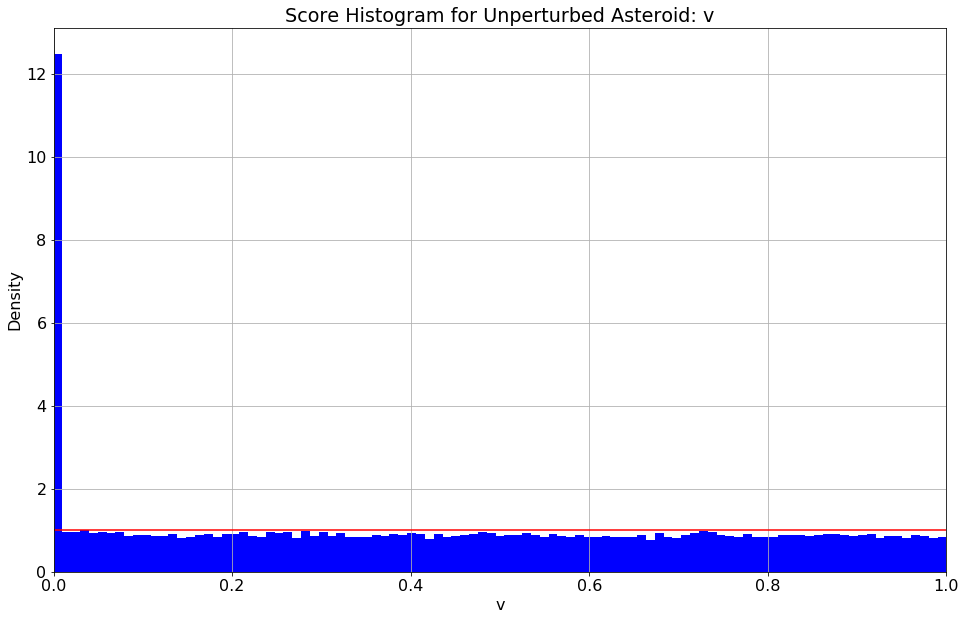

In [29]:
plot_v(ztf_elt_ast, 'Unperturbed Asteroid', v_max=1.0, is_cum=False)

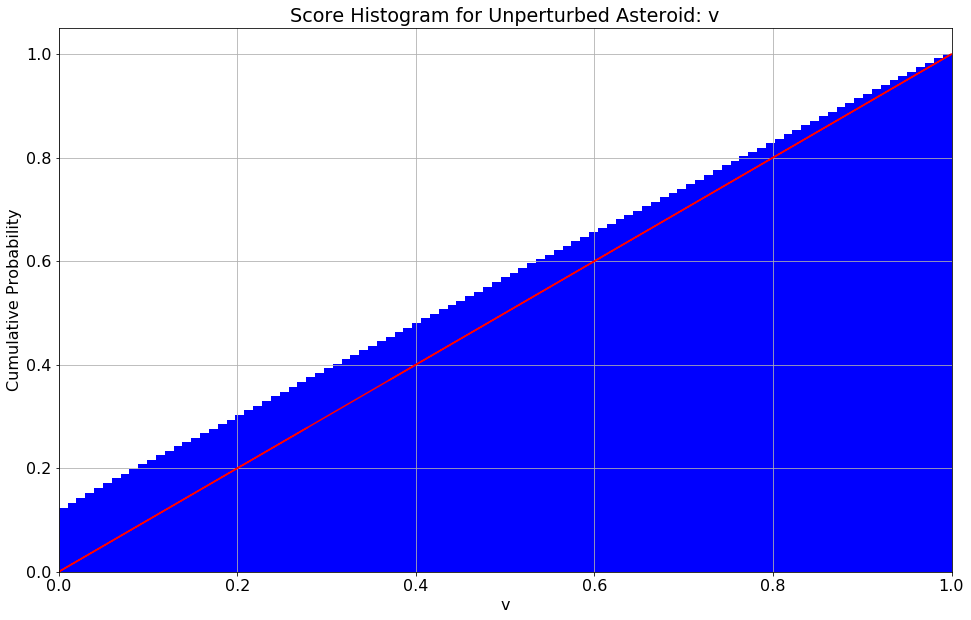

In [30]:
plot_v(ztf_elt_ast, 'Unperturbed Asteroid', v_max=1.0, is_cum=True)

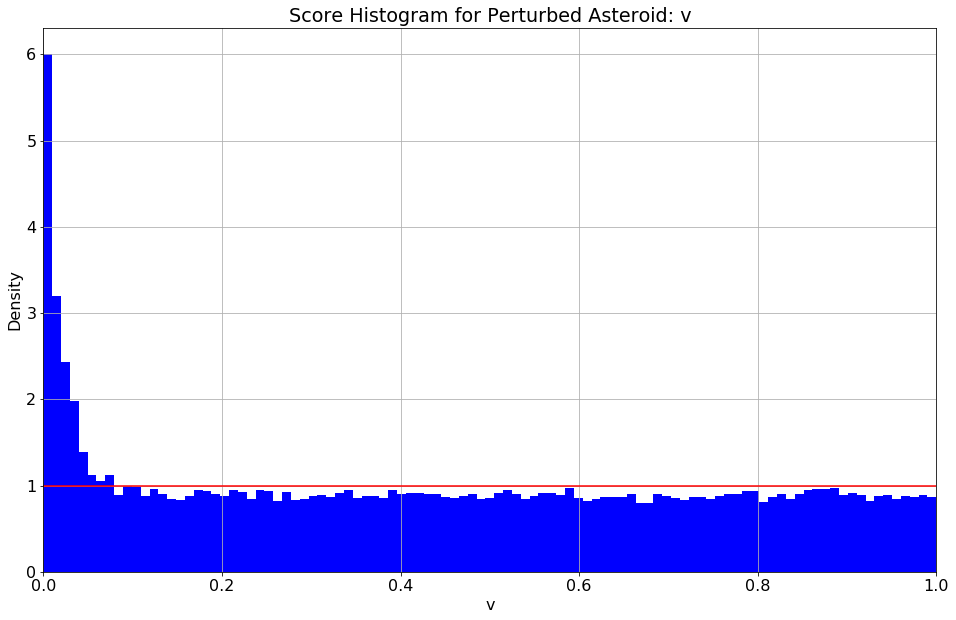

In [31]:
plot_v(ztf_elt_pert, 'Perturbed Asteroid', is_cum=False)

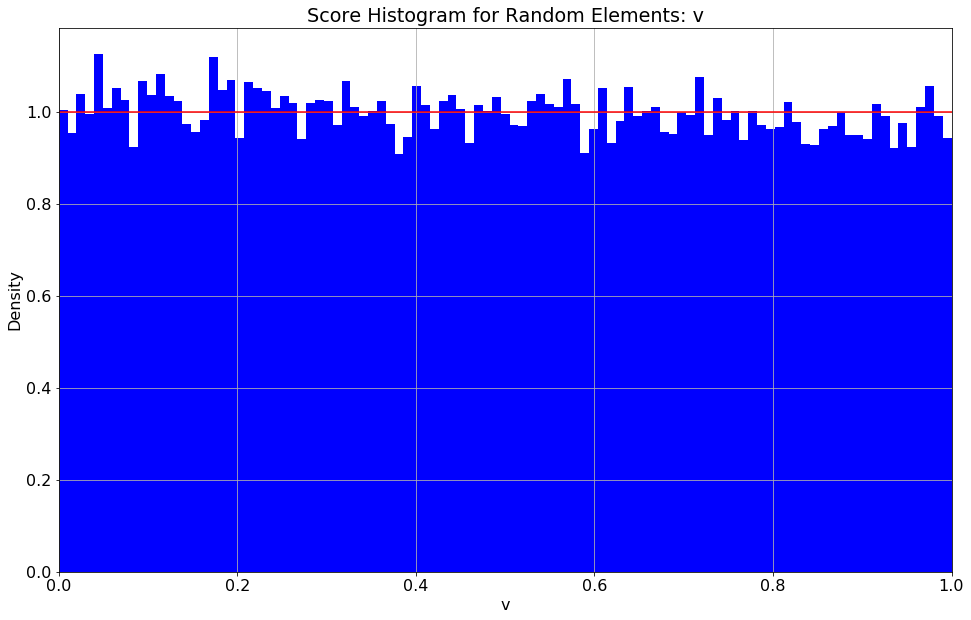

In [32]:
plot_v(ztf_elt_rand, 'Random Elements')

## Mixture Model Fit

In [33]:
# Extract v for first asteroid
element_id = elts.element_id[0]
mask = ztf_elt_ast.element_id == element_id
v = ztf_elt_ast[mask].v.values

In [34]:
# Test values
h = 0.01
lam = 0.5

In [35]:
# Initial guess
h_ = logit(h)
lam_ = np.log(lam)
x0 = np.array([h_, lam_])

In [36]:
# Evaluate log likelihood function and derivatives
L, grad_L, hess_L = mixture_log_like(h=h, lam=lam, x=v)
# Unpack gradient
dL_dh, dL_dl = grad_L

# Report results
print(f'Log Like L(h, lam) = {L:8.6f}')
print(f'dL/dh   = {dL_dh:8.6f}')
print(f'dL/dlam = {dL_dl:8.6f}')

Log Like L(h, lam) = 0.407010
dL/dh   = 40.587779
dL/dlam = 0.874400


In [37]:
# Evaluate objective function and derivatives
F, grad_F, hess_F = mixture_objective_all(x=x0, v=v)
# Unpack gradient
dF_dx, dF_dy = grad_F

# Report results
print(f'Objective  F(x0, v) = {F:8.6f}')
print(f'dF/dx = {dF_dx:8.6f}')
print(f'dF/dy = {dF_dy:8.6f}')

Objective  F(x0, v) = -0.407010
dF/dx = -0.401819
dF/dy = -0.437200


## Check First Derivatives Numerically

In [38]:
# Alias mixture_log_like to log_like and mixture_objective to objective for legibility
log_like = mixture_log_like
objective = mixture_objective
jacobian = mixture_jacobian
hessian = mixture_hessian

In [39]:
# dL_dh by symmetric differences; L is log likelihood
dh = h * 1.0E-4
h_up = h + dh / 2
h_dn = h - dh / 2
dL_dh_num = (log_like(h_up, lam, v)[0] - log_like(h_dn, lam, v)[0]) / dh

# dF_dx by symmetric differences; F is optimization function
dx = h_ * 1.0E-4
x_dn = np.array([h_ - dx/2, lam_])
x_up = np.array([h_ + dx/2, lam_])
dF_dx_num = (objective(x_up, v) - objective(x_dn, v)) / dx

# Compare calculated and numerical derivatives for L and F
err_dL_dh = np.abs(dL_dh - dL_dh_num)
err_dF_dx = np.abs(dF_dx - dF_dx_num)

# Report results
print(f'Log Likelihood function L w.r.t h')
print(f'dL_dh_num = {dL_dh_num:10.6f}')
print(f'Error:      {err_dL_dh:10.2e}')

print(f'\nObjective function F w.r.t x')
print(f'dF_dx_num = {dF_dx_num:10.6f}')
print(f'Error:      {err_dF_dx:10.2e}')

Log Likelihood function L w.r.t h
dL_dh_num =  40.587779
Error:        5.85e-08

Objective function F w.r.t x
dF_dx_num =  -0.401819
Error:        3.23e-09


In [40]:
# dL_dl by symmetric differences
dlam = lam * 1.0E-4
lam_up = lam + dlam / 2
lam_dn = lam - dlam / 2
dL_dl_num = (log_like(h, lam_up, v)[0] - log_like(h, lam_dn, v)[0]) / dlam

# dF_dy by symmetric differences
dy = lam_ * 1.0E-4
y_dn = np.array([h_, lam_ - dy/2])
y_up = np.array([h_, lam_ + dy/2])
dF_dy_num = (objective(y_up, v) - objective(y_dn, v)) / dy

# Compare calculated and numerical derivatives for L and F
err_dL_dl = np.abs(dL_dl - dL_dl_num)
err_dF_dy = np.abs(dF_dy - dF_dy_num)

# Report results
print(f'Log Likelihood function L w.r.t h')
print(f'dL_dl_num = {dL_dl_num:10.6f}')
print(f'Error:      {err_dL_dl:10.2e}')

print(f'\nObjective function F w.r.t y')
print(f'dF_dy_num = {dF_dy_num:10.6f}')
print(f'Error:      {err_dF_dy:10.2e}')

Log Likelihood function L w.r.t h
dL_dl_num =   0.874400
Error:        5.10e-11

Objective function F w.r.t y
dF_dy_num =  -0.437200
Error:        1.75e-10


## Check Second Derivatives Numerically

In [41]:
# Unpack Hessian of L
d2L_dh2 = hess_L[0, 0]
d2L_dhdl = hess_L[0, 1]
d2L_dldh = hess_L[1, 0]
d2L_dl2 = hess_L[1, 1]

In [42]:
# d2L_dh2 from symmetric difference
_, grad_h_up, _ = log_like(h=h_up, lam=lam, x=v)
_, grad_h_dn, _ = log_like(h=h_dn, lam=lam, x=v)
d2L_dh2_num = (grad_h_up[0] - grad_h_dn[0]) / dh
d2L_dhdl_num = (grad_h_up[1] - grad_h_dn[1]) / dh

In [43]:
# d2L_dl2 from symmetric difference
_, grad_l_up, _ = log_like(h=h, lam=lam_up, x=v)
_, grad_l_dn, _ = log_like(h=h, lam=lam_dn, x=v)
d2L_dl2_num = (grad_l_up[1] - grad_l_dn[1]) / dlam
d2L_dldh_num = (grad_l_up[0] - grad_l_dn[0]) / dlam

In [44]:
# Compare calculated and numerical second derivatives for L
err_d2L_dh2 = np.abs(d2L_dh2 - d2L_dh2_num)
err_d2L_dhdl = np.abs(d2L_dhdl - d2L_dhdl_num)
err_d2L_dldh = np.abs(d2L_dldh - d2L_dldh_num)
err_d2L_dl2 = np.abs(d2L_dl2 - d2L_dl2_num)

In [45]:
# Unpack Hessian of F
d2F_dx2 = hess_F[0, 0]
d2F_dxdy = hess_F[0, 1]
d2F_dydx = hess_F[1, 0]
d2F_dy2 = hess_F[1, 1]

In [46]:
# d2F_dx2 from symmetric difference
grad_F_up = jacobian(x_up, v)
grad_F_dn = jacobian(x_dn, v)
d2F_dx2_num = (grad_F_up[0] - grad_F_dn[0]) / dx
d2F_dxdy_num = (grad_F_up[1] - grad_F_dn[1]) / dx

In [47]:
# d2F_dy2 from symmetric difference
grad_F_up = jacobian(y_up, v)
grad_F_dn = jacobian(y_dn, v)
d2F_dydx_num = (grad_F_up[0] - grad_F_dn[0]) / dy
d2F_dy2_num = (grad_F_up[1] - grad_F_dn[1]) / dy

In [48]:
# Compare calculated and numerical second derivatives for F
err_d2F_dx2 = np.abs(d2F_dx2 - d2F_dx2_num)
err_d2F_dxdy = np.abs(d2F_dxdy - d2F_dxdy_num)
err_d2F_dydx = np.abs(d2F_dydx - d2F_dydx_num)
err_d2F_dy2 = np.abs(d2F_dy2 - d2F_dy2_num)

In [49]:
# Report results
print(f'Log Likelihood function L Hessian')
print(f'             Value    ( Error  )')
print(f'd2L_dh2  = {d2L_dh2:10.6f} ({err_d2L_dh2:8.2e})')
print(f'd2L_dhdl = {d2L_dhdl:10.6f} ({err_d2L_dhdl:8.2e})')
print(f'd2L_dldh = {d2L_dldh:10.6f} ({err_d2L_dldh:8.2e})')
print(f'd2L_dl2  = {d2L_dl2:10.6f} ({err_d2L_dl2:8.2e})')

Log Likelihood function L Hessian
             Value    ( Error  )
d2L_dh2  = -22.630008 (3.26e-09)
d2L_dhdl =  86.971469 (7.26e-11)
d2L_dldh =  86.971469 (1.17e-09)
d2L_dl2  =   0.237997 (2.04e-11)


In [50]:
# Report results
print(f'Objective function F Hessian')
print(f'             Value    ( Error  )')
print(f'd2F_dx2  = {d2F_dx2:10.6f} ({err_d2F_dx2:8.2e})')
print(f'd2F_dxdy = {d2F_dxdy:10.6f} ({err_d2F_dxdy:8.2e})')
print(f'd2F_dydx = {d2F_dydx:10.6f} ({err_d2F_dydx:8.2e})')
print(f'd2F_dy2  = {d2F_dy2:10.6f} ({err_d2F_dy2:8.2e})')

Objective function F Hessian
             Value    ( Error  )
d2F_dx2  =  -0.391565 (2.92e-09)
d2F_dxdy =  -0.430509 (3.44e-09)
d2F_dydx =  -0.430509 (1.34e-10)
d2F_dy2  =  -0.496699 (1.45e-10)


## Symbolic Derivatives of Likelihood

In [51]:
sympy.init_printing(use_unicode=True)
x, h, lam = sympy.symbols(['x', 'h', r'\lambda'])

In [52]:
x

In [53]:
lam

In [54]:
N = 1 - sympy.exp(-lam)
N

In [55]:
u = lam * sympy.exp(-lam * x)
u

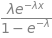

In [56]:
g = u / N
g

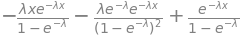

In [57]:
dg = diff(g, lam)
dg

In [58]:
emlx = sympy.exp(-lam*x)
emlx

In [59]:
du = emlx * (1- lam * x)
du

In [60]:
dN = 1 - N
dN

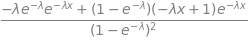

In [61]:
dg_mse = (du*N - u*dN) / N**2
dg_mse

In [62]:
sympy.simplify(dg_mse - dg)

In [63]:
substitutions = [(x, 0.5), (lam, 1.0)]

In [64]:
dg_diff = dg_mse - dg
dg_diff.subs(substitutions)

In [65]:
d2u = diff(u, lam, lam)
d2u

In [66]:
d2u_mse = emlx * (lam * x - 2) * x
d2u_mse

In [67]:
d2u_mse - d2u

In [68]:
d2N = diff(N, lam, lam)
d2N

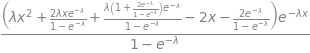

In [69]:
d2g = diff(g, lam, lam)
d2g

In [70]:
d2g_mse = (d2u-2*dN*dg)/N + u*dN/N**2

In [71]:
sympy.simplify(d2g_mse - d2g)

## Optimize Numericaly with scipy.optimize

In [72]:
# Set initial guess
h = 0.01
lam = 1.0
h_ = logit(h)
lam_ = np.log(lam)
x0 = np.array([h_, lam_])

In [73]:
# Review initial guess
print(f'Initial guess:')
print(f'h   = {h:9.6f}   (h_   = {h_:9.6f})')
print(f'lam = {lam:9.6f}   (lam_ = {lam_:9.6f})')
print(f'x0 = ', x0)

Initial guess:
h   =  0.010000   (h_   = -4.595120)
lam =  1.000000   (lam_ =  0.000000)
x0 =  [-4.59511985  0.        ]


In [74]:
# Results table
res_tbl = dict()

In [75]:
# Minimize with Nelder-Mead (no gradients)
res = minimize(fun=objective, x0=x0, args=v, method='Nelder-Mead')
# Save to results table
res_tbl['NM'] = res.copy()
# Display
res

 final_simplex: (array([[2.91272889e+02, 2.71921617e-01],
       [2.91272938e+02, 2.71921618e-01],
       [2.91272842e+02, 2.71921618e-01]]), array([-48.72408672, -48.72408672, -48.72408672]))
           fun: -48.72408672117459
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 59
        status: 0
       success: True
             x: array([2.91272889e+02, 2.71921617e-01])

In [76]:
# Minimize with BFGS (no gradients)
minimize(fun=objective, x0=x0, args=v, method='BFGS')
# Save to results table
res_tbl['BFGS'] = res.copy()
# Display
res

/home/michael/IACS/kepler-sieve/src/candidate_element.py:347: RuntimeWarning: divide by zero encountered in log
  log_f = np.log(f)
/home/michael/IACS/kepler-sieve/src/candidate_element.py:362: RuntimeWarning: divide by zero encountered in true_divide
  dL_dh = df_dh / f
/home/michael/IACS/kepler-sieve/src/candidate_element.py:363: RuntimeWarning: invalid value encountered in true_divide
  dL_dl = df_dl / f
/home/michael/IACS/kepler-sieve/src/candidate_element.py:375: RuntimeWarning: invalid value encountered in true_divide
  d2L_dh2 = d2f_dh2 / f - (df_dh/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:375: RuntimeWarning: divide by zero encountered in true_divide
  d2L_dh2 = d2f_dh2 / f - (df_dh/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:376: RuntimeWarning: invalid value encountered in true_divide
  d2L_dl2 = d2f_dl2 / f - (df_dl/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:377: RuntimeWarning: invalid value encountered in true_di

 final_simplex: (array([[2.91272889e+02, 2.71921617e-01],
       [2.91272938e+02, 2.71921618e-01],
       [2.91272842e+02, 2.71921618e-01]]), array([-48.72408672, -48.72408672, -48.72408672]))
           fun: -48.72408672117459
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 59
        status: 0
       success: True
             x: array([2.91272889e+02, 2.71921617e-01])

In [77]:
# Minimize with BFGS (with gradients)
minimize(fun=objective, x0=x0, args=v, method='BFGS', jac=jacobian)
# Save to results table
res_tbl['BFGS-G'] = res.copy()
# Display
res

/home/michael/IACS/kepler-sieve/src/candidate_element.py:347: RuntimeWarning: divide by zero encountered in log
  log_f = np.log(f)
/home/michael/IACS/kepler-sieve/src/candidate_element.py:362: RuntimeWarning: divide by zero encountered in true_divide
  dL_dh = df_dh / f
/home/michael/IACS/kepler-sieve/src/candidate_element.py:363: RuntimeWarning: invalid value encountered in true_divide
  dL_dl = df_dl / f
/home/michael/IACS/kepler-sieve/src/candidate_element.py:375: RuntimeWarning: invalid value encountered in true_divide
  d2L_dh2 = d2f_dh2 / f - (df_dh/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:375: RuntimeWarning: divide by zero encountered in true_divide
  d2L_dh2 = d2f_dh2 / f - (df_dh/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:376: RuntimeWarning: invalid value encountered in true_divide
  d2L_dl2 = d2f_dl2 / f - (df_dl/f)**2
/home/michael/IACS/kepler-sieve/src/candidate_element.py:377: RuntimeWarning: invalid value encountered in true_di

 final_simplex: (array([[2.91272889e+02, 2.71921617e-01],
       [2.91272938e+02, 2.71921618e-01],
       [2.91272842e+02, 2.71921618e-01]]), array([-48.72408672, -48.72408672, -48.72408672]))
           fun: -48.72408672117459
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 59
        status: 0
       success: True
             x: array([2.91272889e+02, 2.71921617e-01])

In [79]:
# Minimize with Newton-CG (with gradients)
minimize(fun=objective, x0=x0, args=v, method='Newton-CG', jac=jacobian)
# Save to results table
res_tbl['Newton-CG'] = res.copy()
# Display
res

 final_simplex: (array([[2.91272889e+02, 2.71921617e-01],
       [2.91272938e+02, 2.71921618e-01],
       [2.91272842e+02, 2.71921618e-01]]), array([-48.72408672, -48.72408672, -48.72408672]))
           fun: -48.72408672117459
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 59
        status: 0
       success: True
             x: array([2.91272889e+02, 2.71921617e-01])

In [80]:
# Minimize with L-BFGS
minimize(fun=objective, x0=x0, args = v, method='L-BFGS-B', jac=jacobian)

      fun: -2074.1259665882512
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00025306, -0.00045842])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 11
   status: 0
  success: True
        x: array([-1.24732219, 16.50627082])

In [ ]:
v.size

In [ ]:
v.size * 0.2231